Name: Madhuresh Gupta

NU ID: 002198926


Question 1: Pdf is given for a 2 dimentional real valued random vector X

Initializing the packages that are required-

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import scipy.optimize as spo
import pandas as pd

Initalizing the mean and covariance matices along with class priors as given in the problem:

In [2]:
# Mean vectors And covariance matrices
mu01 = [3, 0]
c01 = [[2, 0],
       [0, 1]]

mu02 = [0, 3]
c02 = [[1, 0],
       [0, 2]]

mu1 = [2, 2]
c1 = [[1, 0],
      [0, 1]]

# Class priors
p0 = 0.65
p1 = 0.35


Now we need to generate the random samples using the given probability density function

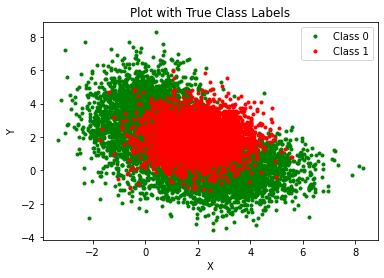

In [3]:
# Generating the samples based on the problems
def generateSamples(numSamples):
    # Generate Samples
    labels = []
    samples = []
    for n in range(0, numSamples):
        val = random.random()
        if val < p0:
            labels.append(0)
            if val < p0 / 2:
                samples.append(np.random.multivariate_normal(mu01, c01))
            else:
                samples.append(np.random.multivariate_normal(mu02, c02))
        else:
            labels.append(1)
            samples.append(np.random.multivariate_normal(mu1, c1))

    return labels, samples


# Generating the samples for datasets
D_20_trainLabels, D_20_trainSamples = generateSamples(20)
D_200_trainLabels, D_200_trainSamples = generateSamples(200)
D_2K_trainLabels, D_2K_trainSamples = generateSamples(2000)
D_10K_validateLabels, D_10K_validateSamples = generateSamples(10000)  #as this is to be used for validation

# Plot data from 10,000 samples for visualization
samp0_10k = [x for (i, x) in enumerate(D_10K_validateSamples) if D_10K_validateLabels[i] == 0]
samp1_10k = [x for (i, x) in enumerate(D_10K_validateSamples) if D_10K_validateLabels[i] == 1]
plt.plot([x[0] for x in samp0_10k], [x[1] for x in samp0_10k], '.', color='green', label='Class 0')
plt.plot([x[0] for x in samp1_10k], [x[1] for x in samp1_10k], '.', color='red', label='Class 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot with True Class Labels')
plt.legend()
plt.show()



Part 1:
We need to theoretically calculate the minimum probability of error using true pdf.

gamma resulting in the minimum error is: 2.1187284323834055
minimum probability of error is: 0.1674
Theoretical gamma is: 1.8571428571428574
Theoretical minimum probability of error is: 0.1684


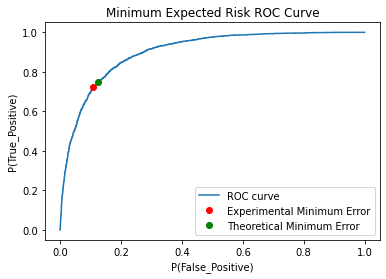

In [4]:
# PART 1
# Generate Discriminant scores
discrim = []

for s in D_10K_validateSamples:
    disc = multivariate_normal.pdf(s, mu1, c1) /\
           (0.5 * multivariate_normal.pdf(s, mu01, c01) + 0.5 * multivariate_normal.pdf(s, mu02, c02))
    discrim.append(disc)

labelDiscrims10k = pd.DataFrame([D_10K_validateLabels, discrim])
labelDiscrims10k = labelDiscrims10k.transpose()
labelDiscrims10k.columns = ['labels', 'discrims']
# Create Gamma thresholds for ROC curve
sortedDisc = sorted(discrim)
gammaVals = [0]
for i, d in enumerate(sortedDisc[0:-1]):
    gammaVals.append((sortedDisc[i]+sortedDisc[i+1])/2.0)

gammaVals.append(sortedDisc[-1] + 1) 
gammas = sorted(gammaVals)

# Generate False and true positive rates
class0Count = len(samp0_10k)
class1Count = len(samp1_10k)
falsePosRate = []
truePosRate = []
perError = []

# discriminant is ordered same as samples so by looping through discriminant, each sample can be observed for each gamma threshold value.
numGammas = len(gammas)
for ind in range(numGammas):
    trueNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] < gammas[ind])].shape[0]
    falseNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] < gammas[ind])].shape[0]
    falsePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] > gammas[ind])].shape[0]
    truePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] > gammas[ind])].shape[0]
    falsePosRate.append(falsePosCount/class0Count)
    truePosRate.append(truePosCount/class1Count)
    perError.append((falsePosCount + falseNegCount)/10000.0)

# Find minimum error for gamma threshold and which index it is
minError = min(perError)
indMinError = perError.index(minError)
print("gamma resulting in the minimum error is: " + str(gammas[indMinError]))
print("minimum probability of error is: " + str(minError))

# find theoretical false positive rate, true positive rate, and error
theoDisc = p0/p1
theoTrueNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] < theoDisc)].shape[0]
theoFalseNegCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] < theoDisc)].shape[0]
theoFalsePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 0) & (labelDiscrims10k['discrims'] > theoDisc)].shape[0]
theoTruePosCount = labelDiscrims10k[(labelDiscrims10k['labels'] == 1) & (labelDiscrims10k['discrims'] > theoDisc)].shape[0]
theoFalsePosRate = theoFalsePosCount/class0Count
theoTruePosRate = theoTruePosCount/class1Count
theoError = (theoFalsePosCount + theoFalseNegCount)/10000.0
print("Theoretical gamma is: " + str(theoDisc))
print("Theoretical minimum probability of error is: " + str(theoError))

# Plot ROC curve
plt.plot(falsePosRate, truePosRate, label='ROC curve')
plt.plot(falsePosRate[indMinError], truePosRate[indMinError], 'ro', label='Experimental Minimum Error')
plt.plot(theoFalsePosRate, theoTruePosRate, 'go', label='Theoretical Minimum Error')
plt.ylabel('P(True_Positive)')
plt.xlabel('P(False_Positive)')
plt.title('Minimum Expected Risk ROC Curve')
plt.legend()
plt.show()

Part 2:

(a) Maximum likelihood parameter estimation technique using 3 logistic linear function of class label posterior functions.

Using Logistic Linear function based approximation on each of 20, 200 and 2000 datasets-

In [5]:
# 20 training samples
print("\n20 training samples dataset")
samp0_20 = [x for (i, x) in enumerate(D_20_trainSamples) if D_20_trainLabels[i] == 0]
samp1_20 = [x for (i, x) in enumerate(D_20_trainSamples) if D_20_trainLabels[i] == 1]
gm_20 = GaussianMixture(n_components=2, n_init=5).fit(samp0_20)
print("Class 0 Estimated Gaussian Weights: " + str(gm_20.weights_))
print("Class 0 Estimated Means: " + str(gm_20.means_))
print("Class 0 Estimated Covariances: " + str(gm_20.covariances_))
m1Hat_20 = np.mean(samp1_20, axis=0)
print("Class 1 Estimated Mean: " + str(m1Hat_20))
cov1Hat_20 = np.cov(samp1_20, rowvar=False)
print("Class 1 Estimated Covariance: " + str(cov1Hat_20))


20 training samples dataset
Class 0 Estimated Gaussian Weights: [0.41172184 0.58827816]
Class 0 Estimated Means: [[ 0.14001795  3.52234274]
 [ 2.52285234 -0.66397011]]
Class 0 Estimated Covariances: [[[ 0.98448294 -0.92722862]
  [-0.92722862  1.18263622]]

 [[ 5.34385709  0.65005156]
  [ 0.65005156  0.39756917]]]
Class 1 Estimated Mean: [2.57792239 2.20333706]
Class 1 Estimated Covariance: [[0.67915258 0.2863319 ]
 [0.2863319  2.11197055]]


Training 200 samples dataset:

In [6]:
# 200 training samples
print("\n200 training samples dataset")
samp0_200 = [x for (i, x) in enumerate(D_200_trainSamples) if D_200_trainLabels[i] == 0]
samp1_200 = [x for (i, x) in enumerate(D_200_trainSamples) if D_200_trainLabels[i] == 1]
gm_200 = GaussianMixture(n_components=2, n_init=5).fit(samp0_200)
print("Class 0 Estimated Gaussian Weights: " + str(gm_200.weights_))
print("Class 0 Estimated Means: " + str(gm_200.means_))
print("Class 0 Estimated Covariances: " + str(gm_200.covariances_))
m1Hat_200 = np.mean(samp1_200, axis=0)
print("Class 1 Estimated Mean: " + str(m1Hat_200))
cov1Hat_200 = np.cov(samp1_200, rowvar=False)
print("Class 1 Estimated Covariance: " + str(cov1Hat_200))


200 training samples dataset
Class 0 Estimated Gaussian Weights: [0.43310438 0.56689562]
Class 0 Estimated Means: [[3.25919061 0.15877542]
 [0.14649056 2.60394144]]
Class 0 Estimated Covariances: [[[ 1.30069548 -0.03909491]
  [-0.03909491  0.97339304]]

 [[ 0.90447733  0.14350481]
  [ 0.14350481  2.40548653]]]
Class 1 Estimated Mean: [2.1539195  1.96549286]
Class 1 Estimated Covariance: [[0.87374943 0.03443978]
 [0.03443978 1.31027917]]


Training 2,000 samples dataset:

In [7]:
# 2,000 training samples
print("\n2,000 training samples dataset")
samp0_2K = [x for (i, x) in enumerate(D_2K_trainSamples) if D_2K_trainLabels[i] == 0]
samp1_2K = [x for (i, x) in enumerate(D_2K_trainSamples) if D_2K_trainLabels[i] == 1]
gm_2K = GaussianMixture(n_components=2, n_init=5).fit(samp0_2K)
print("Class 0 Estimated Gaussian Weights: " + str(gm_2K.weights_))
print("Class 0 Estimated Means: " + str(gm_2K.means_))
print("Class 0 Estimated Covariances: " + str(gm_2K.covariances_))
m1Hat_2K = np.mean(samp1_2K, axis=0)
print("Class 1 Estimated Mean: " + str(m1Hat_2K))
cov1Hat_2K = np.cov(samp1_2K, rowvar=False)
print("Class 1 Estimated Covariance: " + str(cov1Hat_2K))


2,000 training samples dataset
Class 0 Estimated Gaussian Weights: [0.50718825 0.49281175]
Class 0 Estimated Means: [[2.98841677 0.01592355]
 [0.01916776 3.10108106]]
Class 0 Estimated Covariances: [[[ 1.92363178 -0.03930306]
  [-0.03930306  0.97028409]]

 [[ 1.0452431   0.00216789]
  [ 0.00216789  1.99740441]]]
Class 1 Estimated Mean: [1.94421069 1.96059915]
Class 1 Estimated Covariance: [[0.94746285 0.00142717]
 [0.00142717 1.02728877]]


Now using the above trained models in logistic linear function:

In [9]:
# Generating the Discriminant values
discrim20 = np.zeros((len(D_10K_validateSamples)))
discrim200 = np.zeros((len(D_10K_validateSamples)))
discrim2K = np.zeros((len(D_10K_validateSamples)))

print('Part a:')
for i, s in enumerate(D_10K_validateSamples):
    disc20 = multivariate_normal.pdf(s, m1Hat_20, cov1Hat_20) / (gm_20.weights_[0] * multivariate_normal.pdf(s, gm_20.means_[0], gm_20.covariances_[0]) +
               gm_20.weights_[1] * multivariate_normal.pdf(s, gm_20.means_[1], gm_20.covariances_[1]))
    disc200 = multivariate_normal.pdf(s, m1Hat_200, cov1Hat_200) / (gm_200.weights_[0] * multivariate_normal.pdf(s, gm_200.means_[0], gm_200.covariances_[0]) +
              gm_200.weights_[1] * multivariate_normal.pdf(s, gm_200.means_[1], gm_200.covariances_[1]))
    disc2K = multivariate_normal.pdf(s, m1Hat_2K, cov1Hat_2K) / (gm_2K.weights_[0] * multivariate_normal.pdf(s, gm_2K.means_[0], gm_2K.covariances_[0]) +
               gm_2K.weights_[1] * multivariate_normal.pdf(s, gm_2K.means_[1], gm_2K.covariances_[1]))
    discrim20[i] = disc20
    discrim200[i] = disc200
    discrim2K[i] = disc2K

labelDiscrims = pd.DataFrame([D_10K_validateLabels, discrim20, discrim200, discrim2K])
labelDiscrims = labelDiscrims.transpose()
labelDiscrims.columns = ['labels', 'discrim20', 'discrim200', 'discrim2K']
discrims = [discrim20, discrim200, discrim2K]

# Calculating Gamma value for ROC curve
sortedDisc20 = sorted(discrim20)
sortedDisc200 = sorted(discrim200)
sortedDisc2K = sorted(discrim2K)
sortedDiscs = [sortedDisc20, sortedDisc200, sortedDisc2K]

gammaVals20 = np.zeros((len(D_10K_validateSamples)) + 1)
gammaVals200 = np.zeros((len(D_10K_validateSamples)) + 1)
gammaVals2K = np.zeros((len(D_10K_validateSamples)) + 1)
for i in range(len(D_10K_validateSamples) - 1):
    gammaVals20[i + 1] = (sortedDisc20[i] + sortedDisc20[i + 1]) / 2.0
    gammaVals200[i + 1] = (sortedDisc200[i] + sortedDisc200[i + 1]) / 2.0
    gammaVals2K[i + 1] = (sortedDisc2K[i] + sortedDisc2K[i + 1]) / 2.0

gammaVals20[-1] = sortedDisc20[-1] + 1
gammaVals200[-1] = sortedDisc200[-1] + 1
gammaVals2K[-1] = sortedDisc2K[-1] + 1  
gammas = [sorted(gammaVals20), sorted(gammaVals200), sorted(gammaVals2K)]

# Generate False and true positive rates
class0Count = len(samp0_10k)
class1Count = len(samp1_10k)
falsePosRate2K = []
truePosRate2K = []
perError2K = []
falsePosRate200 = []
truePosRate200 = []
perError200 = []
falsePosRate20 = []
truePosRate20 = []
perError20 = []


numGammas = len(gammas[0])
for ind in range(numGammas):
    if ind % 1000 == 0:
      trueNegCount2K = \
          labelDiscrims[(labelDiscrims['labels'] == 0) & (labelDiscrims['discrim2K'] < gammas[0][ind])].shape[0]
      falseNegCount2K = \
          labelDiscrims[(labelDiscrims['labels'] == 1) & (labelDiscrims['discrim2K'] < gammas[0][ind])].shape[0]
      falsePosCount2K = \
          labelDiscrims[(labelDiscrims['labels'] == 0) & (labelDiscrims['discrim2K'] > gammas[0][ind])].shape[0]
      truePosCount2K = \
          labelDiscrims[(labelDiscrims['labels'] == 1) & (labelDiscrims['discrim2K'] > gammas[0][ind])].shape[0]
      trueNegCount200 = \
          labelDiscrims[(labelDiscrims['labels'] == 0) & (labelDiscrims['discrim200'] < gammas[1][ind])].shape[0]
      falseNegCount200 = \
          labelDiscrims[(labelDiscrims['labels'] == 1) & (labelDiscrims['discrim200'] < gammas[1][ind])].shape[0]
      falsePosCount200 = \
          labelDiscrims[(labelDiscrims['labels'] == 0) & (labelDiscrims['discrim200'] > gammas[1][ind])].shape[0]
      truePosCount200 = \
          labelDiscrims[(labelDiscrims['labels'] == 1) & (labelDiscrims['discrim200'] > gammas[1][ind])].shape[0]
      trueNegCount20 = \
          labelDiscrims[(labelDiscrims['labels'] == 0) & (labelDiscrims['discrim20'] < gammas[2][ind])].shape[0]
      falseNegCount20 = \
          labelDiscrims[(labelDiscrims['labels'] == 1) & (labelDiscrims['discrim20'] < gammas[2][ind])].shape[0]
      falsePosCount20 = \
          labelDiscrims[(labelDiscrims['labels'] == 0) & (labelDiscrims['discrim20'] > gammas[2][ind])].shape[0]
      truePosCount20 = \
          labelDiscrims[(labelDiscrims['labels'] == 1) & (labelDiscrims['discrim20'] > gammas[2][ind])].shape[0]
    
    falsePosRate2K.append(falsePosCount2K / class0Count)
    truePosRate2K.append(truePosCount2K / class1Count)
    perError2K.append((falsePosCount2K + falseNegCount2K) / 10000.0)
    falsePosRate200.append(falsePosCount200 / class0Count)
    truePosRate200.append(truePosCount200 / class1Count)
    perError200.append((falsePosCount200 + falseNegCount200) / 10000.0)
    falsePosRate20.append(falsePosCount20 / class0Count)
    truePosRate20.append(truePosCount20 / class1Count)
    perError20.append((falsePosCount20 + falseNegCount20) / 10000.0)

Part a:


Printing the minimum error for gamma:

In [10]:

minError20 = min(perError20)
indMinError20 = perError20.index(minError20)
print("The gamma resulting in the minimum error with 20 training samples is: " + str(gammas[0][indMinError20]))
print("The minimum probability of error with 20 training samples is: " + str(minError20))
minError200 = min(perError200)
indMinError200 = perError200.index(minError200)
print("The gamma resulting in the minimum error with 200 training samples is: " + str(gammas[1][indMinError200]))
print("The minimum probability of error with 200 training samples is: " + str(minError200))
minError2K = min(perError2K)
indMinError2K = perError2K.index(minError2K)
print("The gamma resulting in the minimum error with 2K training samples is: " + str(gammas[2][indMinError2K]))
print("The minimum probability of error with 2K training samples is: " + str(minError2K))

The gamma resulting in the minimum error with 20 training samples is: 8.078760475416715
The minimum probability of error with 20 training samples is: 0.2685
The gamma resulting in the minimum error with 200 training samples is: 2.03576502015759
The minimum probability of error with 200 training samples is: 0.1759
The gamma resulting in the minimum error with 2K training samples is: 1.2447104967347786
The minimum probability of error with 2K training samples is: 0.1797


Plotting the ROC curves:

Using 20 samples dataset-

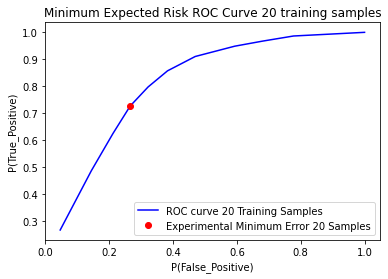

In [11]:
plt.plot(falsePosRate20, truePosRate20, 'b', label='ROC curve 20 Training Samples')
plt.plot(falsePosRate20[indMinError20], truePosRate20[indMinError20], 'ro',
         label='Experimental Minimum Error 20 Samples')
plt.ylabel('P(True_Positive)')
plt.xlabel('P(False_Positive)')
plt.title('Minimum Expected Risk ROC Curve 20 training samples')
plt.legend()
plt.show()

Using 200 samples dataset:

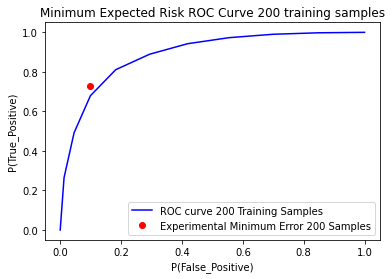

In [14]:
plt.plot(falsePosRate200, truePosRate200, 'b', label='ROC curve 200 Training Samples')
plt.plot(falsePosRate200[indMinError200], truePosRate20[indMinError200], 'ro',
         label='Experimental Minimum Error 200 Samples')
plt.ylabel('P(True_Positive)')
plt.xlabel('P(False_Positive)')
plt.title('Minimum Expected Risk ROC Curve 200 training samples')
plt.legend()
plt.show()

Using 2,000 samples dataset:

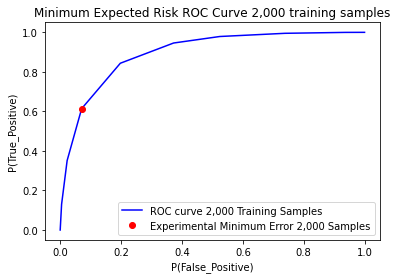

In [13]:
plt.plot(falsePosRate2K, truePosRate2K, 'b', label='ROC curve 2,000 Training Samples')
plt.plot(falsePosRate2K[indMinError2K], truePosRate2K[indMinError2K], 'ro',
         label='Experimental Minimum Error 2,000 Samples')
plt.ylabel('P(True_Positive)')
plt.xlabel('P(False_Positive)')
plt.title('Minimum Expected Risk ROC Curve 2,000 training samples')
plt.legend()
plt.show()

Perform Logistic linear and quadratic classification:

[ 4.46013729 -0.64302142 -0.75586846]
Probability of error 20 Train Samples: 0.3499


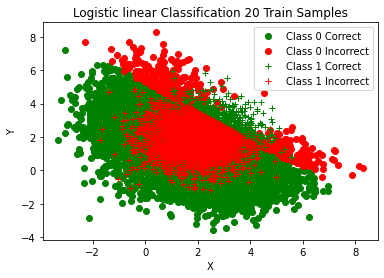

[ 2.27429226 -0.42170852 -0.35877264]
Probability of error 200 Train Samples: 0.3491


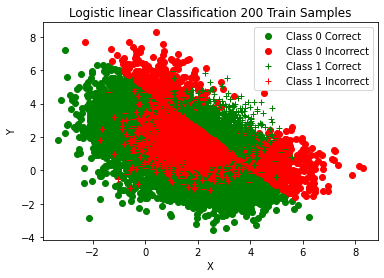

[ 1.87233354 -0.33200356 -0.32234977]
Probability of error 2,000 Train Samples: 0.3527


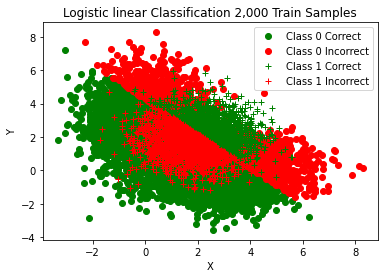

In [15]:
def logisticFunctionClassificationLikelihood(modelParam, trainData, trainLablels, fit):
    if fit == 'linear':
        z = [np.r_[1, samp] for samp in trainData]
    elif fit == 'quadratic':
        z = [np.r_[1, samp[0], samp[1], samp[0] ** 2, samp[0] * samp[1], samp[1] ** 2] for samp in trainData]
    else:
        print('Enter correct classification')
        exit(-1)
        return
    # Logistic values are 1/(1+e^wz), where w is modelParamLin input and z is as calculated above
    
    logVals = [1.0/(1 + np.exp(np.matmul(modelParam, z[samp]))) for samp in range(len(trainData))]
    # Likelihood is 1 - logVal if label is 0
    correctLiklihood = [(1-logVals[i]) if trainLablels[i] == 0 else logVals[i] for i in range(len(trainData))]
    # Return negative mean of log likelihoods4
    return -1 * np.mean(np.log(correctLiklihood))

# Function to perform logistic-based binary classification and return the model parameters
def optimizeLogisticClassification(trainData, trainLabels, initParams, fit):
    optimizeResult = spo.minimize(fun=logisticFunctionClassificationLikelihood, x0=initParams,
                                  args=(trainData, trainLabels, fit), method='Nelder-Mead')
                                  #options={'maxiter':5000, 'fatol':0.001})

    if not optimizeResult.success:
        print(optimizeResult.message)
        exit(-1)
    return optimizeResult.x

# Function Calculates minimum error probability on validation set using given parameters. Also plots the validation
def plotLogClassPerformance(params, fit, info=''):
    # Calculate minimum error probabilities on validation set based on fit type and parameters
    if fit == 'linear':
        likelihoods = [params[0] + params[1] * D_10K_validateSamples[i][0] +
                       params[2] * D_10K_validateSamples[i][1] for i in range(10000)]
    elif fit == 'quadratic':
        likelihoods = [params[0] + params[1] * D_10K_validateSamples[i][0] +
                       params[2] * D_10K_validateSamples[i][1] +
                       params[3] * (D_10K_validateSamples[i][0] ** 2) +
                       params[4] * D_10K_validateSamples[i][0] * D_10K_validateSamples[i][1] +
                       params[5] * (D_10K_validateSamples[i][1] ** 2) for i in range(10000)]
    else:
        print('Incorrect fit')
        exit(-1)
        return

    decisions = [int(i < 0.5) for i in likelihoods]
    numErrors = 0
    for i in range(10000):
        if decisions[i] != D_10K_validateLabels[i]:
            numErrors += 1
    errorProb = numErrors/10000.0
    print('Probability of error ' + info +': ' + str(errorProb))

    # Plot Data As Classified Correct or incorrect
    class0Correct = [s for (i, s) in enumerate(D_10K_validateSamples) if D_10K_validateLabels[i] == 0 and
                     decisions[i] == 0]
    class0Incorrect = [s for (i, s) in enumerate(D_10K_validateSamples) if D_10K_validateLabels[i] == 0 and
                       decisions[i] == 1]
    class1Correct = [s for (i, s) in enumerate(D_10K_validateSamples) if D_10K_validateLabels[i] == 1 and
                     decisions[i] == 1]
    class1Incorrect = [s for (i, s) in enumerate(D_10K_validateSamples) if D_10K_validateLabels[i] == 1 and
                       decisions[i] == 0]

    plt.plot([x[0] for x in class0Correct], [x[1] for x in class0Correct], 'o', color='green',
             label='Class 0 Correct')
    plt.plot([x[0] for x in class0Incorrect], [x[1] for x in class0Incorrect], 'o', color='red',
             label='Class 0 Incorrect')
    plt.plot([x[0] for x in class1Correct], [x[1] for x in class1Correct], '+', color='green',
             label='Class 1 Correct')
    plt.plot([x[0] for x in class1Incorrect], [x[1] for x in class1Incorrect], '+', color='red',
             label='Class 1 Incorrect')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Logistic ' + fit + ' Classification ' + info)
    plt.legend()
    plt.show()


# Perform logistic linear classification
modelParamLin = np.array([0, 0, 0])
modelParamLin = optimizeLogisticClassification(D_20_trainSamples, D_20_trainLabels, modelParamLin, 'linear')
print(modelParamLin)
plotLogClassPerformance(modelParamLin, 'linear', '20 Train Samples')
modelParamLin = optimizeLogisticClassification(D_200_trainSamples, D_200_trainLabels, modelParamLin, 'linear')
print(modelParamLin)
plotLogClassPerformance(modelParamLin, 'linear', '200 Train Samples')
modelParamLin = optimizeLogisticClassification(D_2K_trainSamples, D_2K_trainLabels, modelParamLin, 'linear')
print(modelParamLin)
plotLogClassPerformance(modelParamLin, 'linear', '2,000 Train Samples')


Quadratic classification:

Maximum number of function evaluations has been exceeded.
[ 0.16383459 -0.61674328 -0.21473171  0.60065981 -1.39651777  0.70038928]
Probability of error 20 Train Samples: 0.1925


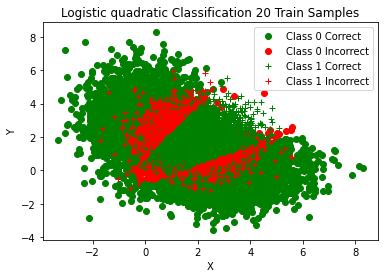

[ 2.38941516 -1.85527771 -0.5502101   0.58376697 -0.6419087   0.35218148]
Probability of error 200 Train Samples: 0.1771


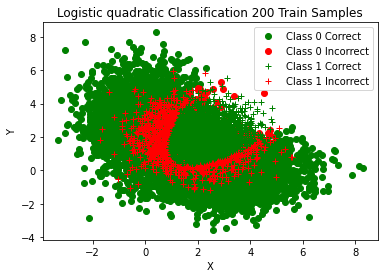

[ 1.60503141 -1.10815865 -1.01722571  0.45544063 -0.56297651  0.41631147]
Probability of error 2,000 Train Samples: 0.1852


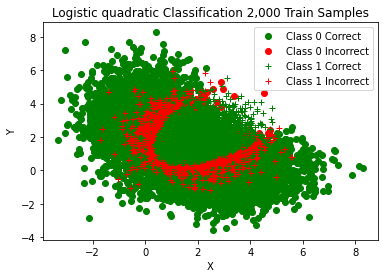

In [16]:

# Perform logistic quadratic classification
modelParamQuad = np.array([0, 0, 0, 0, 0, 0])
modelParamQuad = optimizeLogisticClassification(D_20_trainSamples, D_20_trainLabels, modelParamQuad, 'quadratic')
print(modelParamQuad)
plotLogClassPerformance(modelParamQuad, 'quadratic', '20 Train Samples')
modelParamQuad = optimizeLogisticClassification(D_200_trainSamples, D_200_trainLabels, modelParamQuad, 'quadratic')
print(modelParamQuad)
plotLogClassPerformance(modelParamQuad, 'quadratic', '200 Train Samples')
modelParamQuad = optimizeLogisticClassification(D_2K_trainSamples, D_2K_trainLabels, modelParamQuad, 'quadratic')
print(modelParamQuad)
plotLogClassPerformance(modelParamQuad, 'quadratic', '2,000 Train Samples')